# Generative Adversarial Networks (GANs)

In this notebook, we will:

- Introduce the basic architecture of GANs, including the roles of the **Generator** and **Discriminator**
- Explain the training process and key challenges
- Implement a simple GAN on MNIST dataset.
- Implement a simple DCGAN (Deep Convolutional GAN) on CelebA dataset.
- Discuss common GAN variants such as Conditional GANs, CycleGANs, and others

## Introduction to GANs

Generative Adversarial Networks (GANs) were introduced by Ian Goodfellow in 2014 [paper](https://arxiv.org/abs/1406.2661). The core idea is to have two neural networks—a **Generator** and a **Discriminator**—competing against each other:

- **Generator (G):** Takes in random noise (from a latent space) and attempts to generate realistic data (e.g., images).
- **Discriminator (D):** Receives both real data (from the training set) and fake data (produced by the generator) and tries to distinguish between the two.

During training, G improves at fooling D, while D gets better at detecting fakes. This adversarial process drives the generator to produce increasingly realistic outputs.

<div style="text-align: center;">
    <img src="https://developers.google.com/static/machine-learning/gan/images/gan_diagram.svg" alt="developers.google.com" width="900">
</div>

Image Source: [developers.google.com](https://developers.google.com/static/machine-learning/gan/images/gan_diagram.svg)

### Key Points

- **Adversarial Loss:** Both networks are trained with opposing objectives. The generator’s loss is designed to maximize the discriminator’s error, while the discriminator minimizes classification errors.
$$
\min_{G} \max_{D} V(D, G) = \mathbb{E}_{x \sim p_{\text{data}}(x)} \left[ \log D(x) \right] + \mathbb{E}_{z \sim p_{z}(z)} \left[ \log \big(1 - D(G(z))\big) \right]
$$

- **Training Challenges:** GANs are notoriously difficult to train due to issues such as mode collapse, non-convergence, and delicate balance between the two networks.

## Training a Simple GAN on MNIST

In the following we will import the Generator and Discriminator Networks from the [gan.py](./gan/gan.py) file. and import the nessisarly packages.

In [1]:
import inspect

import matplotlib.pyplot as plt
import torch
import torchvision
from IPython.display import Code, clear_output, display
from rich.pretty import pprint
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

# Set manual seed for reproducibility
seed = 42
print("Random Seed: ", seed)
torch.manual_seed(seed)

# Decide which device we want to run on
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Random Seed:  42
Device: cuda


## Data Preparation

For this demonstration, we will use the MNIST dataset. Later, we will train a DCGAN on CelebA to see how the model adapts to more complex images.

We will normalize the images to the range [-1, 1] (a common practice for GANs) and load the data using PyTorch’s `DataLoader`.

In [2]:
from gan.gan import get_config, get_dataloader

# Configuration dictionary
config = get_config('./gan/config.yaml')

dataloader = get_dataloader(config)

pprint(config)

{
│   'use_cuda': True,
│   'data_root': '../../data',
│   'batch_size': 64,
│   'epochs': 50,
│   'lr': 0.0001,
│   'beta1': 0.3,
│   'latent_dim': 100,
│   'log_interval': 100,
│   'checkpoint_interval': 10,
│   'checkpoint_path': './models/gan_checkpoint.pth',
│   'wandb_project': 'GAN_MNIST',
│   'num_eval_samples': 16,
│   'weight_decay': 1e-05
}

## Defining the GAN Architecture

### Generator

The generator takes a latent vector (random noise) as input and produces an image. We use a series of fully connected (dense) layers to transform the latent space into the image dimensions.


In [3]:
from gan.gan import Generator

generator = Generator(config['latent_dim']).to(device)

display(Code(inspect.getsource(Generator), language="python"))

class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.net = nn.Sequential(
            nn.Linear(self.latent_dim, 128),
            nn.ReLU(),

            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),

            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 28*28),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.net(z)
        img = img.view(z.size(0), 1, 28, 28)
        return img

### Discriminator

The discriminator is a convolutional network that takes an image as input and outputs a single scalar representing the probability that the input is real.

In [4]:
from gan.gan import Discriminator

discriminator = Discriminator().to(device)

display(Code(inspect.getsource(Discriminator), language="python"))

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.LeakyReLU(0.2),

            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.net(img_flat)
        return validity

### Visualizing the Results

In [5]:
def visualize_generated_images(generator, discriminator, config, device, epoch=None):
    """
    Visualize generated images and their discriminator labels.

    Args:
        generator (torch.nn.Module): The generator model.
        discriminator (torch.nn.Module): The discriminator model.
        config (dict): Configuration dictionary containing latent_dim and epochs.
        device (torch.device): The device to run the models on.
        epoch (int, optional): Current epoch number for the title. Defaults to None.
    """
    generator.eval()
    discriminator.eval()

    noise = torch.randn(5, config["latent_dim"], device=device)

    with torch.no_grad():
        fake_imgs = generator(noise)
        labels = discriminator(fake_imgs)

    fake_imgs = fake_imgs.cpu().detach()
    labels = labels.cpu().detach()

    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for idx, ax in enumerate(axes):
        ax.imshow(fake_imgs[idx].squeeze().numpy(), cmap='gray')
        ax.axis('off')
        ax.set_title(f"Label: {labels[idx].item():.2f}")
    title = f"Epoch {epoch+1}/{config['epochs']}" if epoch is not None else "Generated Images"
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
    plt.close(fig)

## Training the GAN

We now define the training loop. In each iteration:

1. **Discriminator Training:**
   - Use a batch of real images and label them as 1.
   - Generate a batch of fake images from noise and label them as 0.
2. **Generator Training:**
   - Generate a batch of fake images.
   - Compute the loss against a target label of 1 (i.e., tricking the discriminator).

For simplicity, we use the Binary Cross Entropy loss. You may explore other loss functions in advanced exercises.

### Breaking Down the Minimax Loss

$$
\min_{G} \max_{D} V(D, G) = \mathbb{E}_{x \sim p_{\text{data}}(x)} \left[ \log D(x) \right] + \mathbb{E}_{z \sim p_{z}(z)} \left[ \log \big(1 - D(G(z))\big) \right]
$$

- **Discriminator’s Role:**  
  The discriminator aims to correctly classify real and fake data:
  - For real data $ x $, it wants $ D(x) $ (the probability of being real) to be close to 1, maximizing $\log D(x)$.
  - For generated (fake) data $ G(z) $, it wants $ D(G(z)) $ to be close to 0, maximizing $\log\big(1 - D(G(z))\big)$.

- **Generator’s Role:**  
  The generator aims to "fool" the discriminator. Although its objective can be written as minimizing $\log\big(1 - D(G(z))\big)$, this often leads to vanishing gradients. Therefore, a common alternative is for the generator to maximize $\log D(G(z))$ (or equivalently, minimize $-\log D(G(z))$).

#### Connection to Binary Cross Entropy (BCE)

The Binary Cross Entropy loss for a single sample is defined as:

$$
\text{BCE}(p, y) = -\Big[ y \log(p) + (1 - y) \log\big(1 - p\big) \Big]
$$

where:
- $ p $ is the predicted probability (e.g., $ D(x) $).
- $ y $ is the true label (1 for real data, 0 for fake data).

##### **Derivation for Real Data ($ y = 1 $)**

Substitute $ y = 1 $ into the BCE formula:

$$
\text{BCE}(D(x), 1) = -\Big[ 1 \cdot \log(D(x)) + 0 \cdot \log\big(1-D(x)\big) \Big] = -\log\big(D(x)\big)
$$

This directly corresponds to the term $\log D(x)$ in the GAN minimax loss.

##### **Derivation for Fake Data ($ y = 0 $)**

Substitute $ y = 0 $:

$$
\text{BCE}(D(G(z)), 0) = -\Big[ 0 \cdot \log(D(G(z))) + 1 \cdot \log\big(1-D(G(z))\big) \Big] = -\log\big(1-D(G(z))\big)
$$

This matches the term $\log\big(1-D(G(z))\big)$ in the minimax loss.

### Loss Functions

- The **discriminator’s loss** can be seen as the sum of two BCE losses:
  $$
  L_D = -\log\big(D(x)\big) - \log\big(1-D(G(z))\big) = \boxed{\text{BCE}(D(x), 1) + \text{BCE}(D(G(z)), 0)}
  $$
- The **generator’s loss** (using the non-saturating version) becomes:
  $$
  L_G = -\log\big(D(G(z))\big) = \boxed{\text{BCE}(D(G(z)), 1)}
  $$

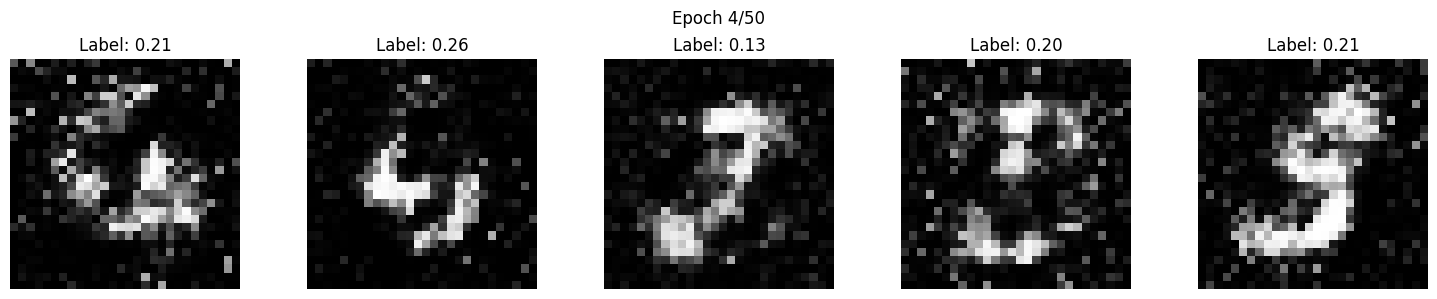

Epoch 5/50:   0%|          | 0/938 [00:00<?, ?it/s]

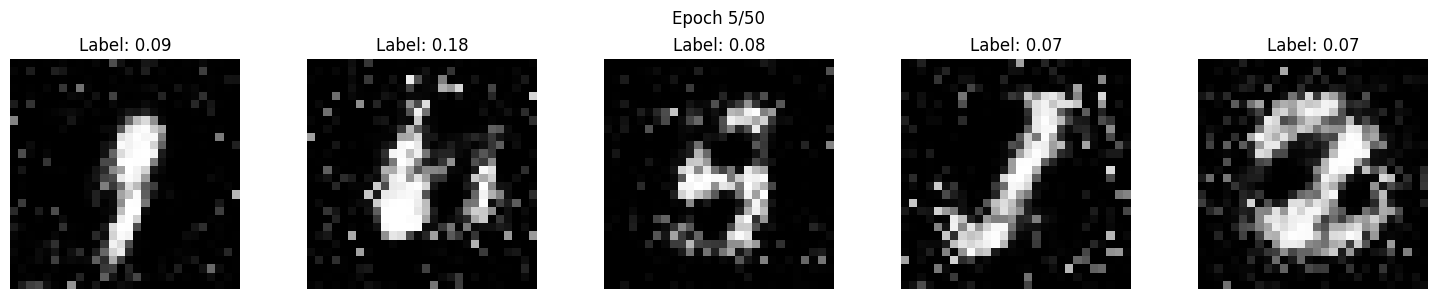

In [6]:
# Setup optimizers for both G and D
optimizerG = optim.Adam(generator.parameters(), lr=config["lr"], betas=(config['beta1'], 0.9), weight_decay=config['weight_decay'])
optimizerD = optim.Adam(discriminator.parameters(), lr=config["lr"], betas=(config['beta1'], 0.9), weight_decay=config['weight_decay'])


print("Starting Training Loop...")
for epoch in range(5):
    generator.train()
    discriminator.train()
    for i, (imgs, _) in enumerate(tqdm(dataloader, desc=f"Epoch {epoch+1}/{config['epochs']}", leave=False)):
        batch_size = imgs.size(0)
        imgs = imgs.to(device)

        # Define adversarial ground truths
        valid = torch.ones(batch_size, 1, device=device)
        fake = torch.zeros(batch_size, 1, device=device)

        # -----------------
        #  Train Generator
        # -----------------
        optimizerG.zero_grad()

        # Generate a batch of images
        z = torch.randn(batch_size, config["latent_dim"], device=device)
        fake_imgs = generator(z)

        # Loss: generator tries to fool the discriminator
        g_loss = F.binary_cross_entropy(discriminator(fake_imgs), valid)
        g_loss.backward()
        optimizerG.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizerD.zero_grad()

        real_loss = F.binary_cross_entropy(discriminator(imgs), valid)
        fake_loss = F.binary_cross_entropy(discriminator(fake_imgs.detach()), fake)

        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizerD.step()

    # Clear the output to keep the notebook clean
    if epoch % 3 == 0:
        clear_output(wait=True)

    # Plot 5 generated images after each epoch to show the generator's training progress
    visualize_generated_images(generator, discriminator, config, device, epoch)

Since training a GAN can be time-consuming before the generator produces plausible images, we can directly load pre-trained model weights from [huggingface.co](https://huggingface.co/hussamalafandi/GAN_MNIST) to expedite the process.

In [7]:
from huggingface_hub import hf_hub_download

# Download the state dicts from Hugging Face Hub
gen_weights_path = hf_hub_download(repo_id="hussamalafandi/GAN_MNIST", filename="generator.pth")
disc_weights_path = hf_hub_download(repo_id="hussamalafandi/GAN_MNIST", filename="discriminator.pth")

# Load the state dicts into the models
generator.load_state_dict(torch.load(gen_weights_path, map_location=device))
discriminator.load_state_dict(torch.load(disc_weights_path, map_location=device))

# Set the models to evaluation mode
generator.eval()
generator = generator.to(device)

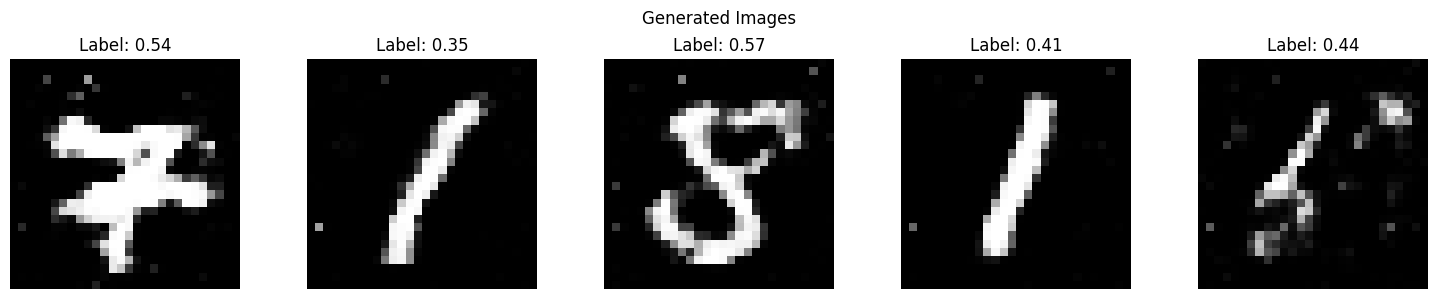

In [9]:
visualize_generated_images(generator, discriminator, config, device)


# Deep Convolutional GANs (DCGANs)

While simple GAN architectures perform reasonably well on small grayscale images, they often struggle to effectively capture local and global structures due to the flattening of input images.

To address this limitation, we can utilize convolutional layers, which are particularly effective at preserving spatial hierarchies and capturing intricate image features. Incorporating convolutional layers significantly enhances the performance of GAN models, leading to improved quality in generated images.

![alt text](https://sthalles.github.io/assets/dcgan/GANs.png)

Image source: [sthalles.github.io](https://sthalles.github.io/intro-to-gans/)

In the following example, we import basic generator and discriminator network architectures from [dcgan/models.py](./dcgan/models.py)

In [ ]:
import torch
from dcgan.models import Generator

# Decide which device we want to run on
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

inference_config = {
    "latent_dim": 100,
    "image_size": 64,     # output image size (64x64)
    "nc": 3,              # number of channels (3 for RGB)
    "ngf": 64,            # generator feature map size
    "ndf": 64,            # discriminator feature map size
}


### Visualizing the Generator and Discriminator Architectures

In this section, we will inspect the source code and architecture of the Generator and Discriminator models used in the DCGAN implementation. This will help us understand the structure and design choices made for these networks.

In [ ]:


generator_source = inspect.getsource(Generator)
display(Code(generator_source, language='python'))


We can also use the `torchinfo` library to get a summary of the generator model.

In [ ]:
import torchinfo

generator = Generator(inference_config)

torchinfo.summary(generator,
                  input_size=(16, inference_config["latent_dim"], 1, 1),
                  col_names=["input_size", "output_size"],
                  row_settings=["var_names"])

Since training a GAN model on the CelebA dataset can be time-consuming, we can download the pretrained model from the HuggingFace [repository](https://huggingface.co/hussamalafandi/DCGAN_CelebA)

In [ ]:
from huggingface_hub import hf_hub_download

# Download the state dicts from Hugging Face Hub
gen_weights_path = hf_hub_download(repo_id="hussamalafandi/DCGAN_CelebA", filename="generator.pth")

# Load the state dicts into the models
generator.load_state_dict(torch.load(gen_weights_path, map_location=device))
generator.eval()
generator = generator.to(device)

Create random noise as input for the generator (latent vector)

In [ ]:
# Create a random noise vector for inference
noise = torch.randn(1, inference_config["latent_dim"], 1, 1).to(device)  # shape should match what the generator expects

# Run inference: generate an image
with torch.no_grad():
    generated_image = generator(noise)

In [ ]:
import matplotlib.pyplot as plt


img = generated_image.squeeze(0).detach().cpu()

# Normalize the image to [0, 1] for visualization
img = (img + 1) / 2

plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
plt.axis("off")
plt.show()


# Conditional GAN

# Exploring GAN Variants

Once you are comfortable with the basic GAN, you may explore the following variants:

- **CycleGAN:** Used for image-to-image translation without paired examples (e.g., converting horses to zebras). 
- **StyleGAN:** Generates ultra-realistic images by controlling high-level features (e.g., pose, style) and fine details separately through style-based layers.

## Exercise
- Experiment with different loss functions or network architectures to see how the output quality changes.
- Try using a different dataset (such as fashion mnist) and adjust the network layers accordingly.